## **Installation** 

- Install Docker and Conda.
- sudo usermod -aG docker "$USER" (on Linux)
- conda create -n scanflow python=3.6
- source activate scanflow
- git clone https://github.com/gusseppe/scanflow
- cd scanflow
- pip install -r requirements.txt

**In the future**

- Install Docker and Conda.
- pip install scanflow

## **Run scanflow server** 

It starts the **Scanflow UI** (dashboard) and **Scanflow API** (REST):

- python cli.py server

Then go to:

- http://localhost:8050

Note: By default server_port = 8050.

Use python cli.py --help for more information.

You will see the home page (Scanflow UI).

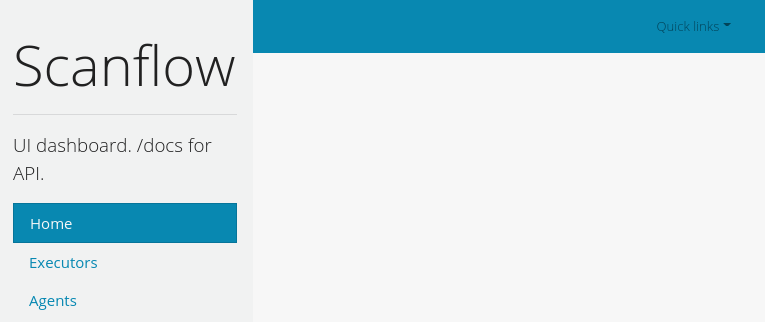

In [43]:
from IPython.display import Image
Image("sc/home.png", width=500, height=500)

## **Steps**

- **Training**: Define the training executor using Pytorch and the MNIST data.
- **Inference**: Define an inference executor (batch) and a Predictor (online) to make predictions using a trained model.
    - Aditionally, we can define the **Agents**: Supervisor, Checker, Improver and Planner (more explanation about them below).
- **Detector training + Detector Inference**: Define a drift detector for both anomaly detection and anomaly picker. Built-in Scanflow executor (from submitted paper)(https://colab.research.google.com/drive/1t0EgpPk5_mEMNb_AvN7yJ_Tz88bqgS9A)

    - **Detector training**: Define a detector training executor that will be trained on `x_train`.
    - **Detector Inference**: Define an inference executor with the trained Detector model that will be used by the Checker agent.
    
- **Retraining**: Define a retraining executor to retrain the model using `x_train + x_chosen`. It will be used by the Improver agent.
- **Labeling**: Define a labeling executor to label the `x_chosen` artifact (Future work). 
- **Custom apps**: Call the batch/online inference executor/predictor from a web application.

# **Definition and Deployment** 📑

Here we start the definition of each step, it consists of setting the images, requirements, python scripts and parameters. This definition is set just once and the behaviour of each step can be changed by its parameters. In a production system, this notebook should be run once in order to start the network, tracker, executors and agents as containers. Then, these containers can be executed or reached on demand by using Scanflow API (e.g. call the Predictor or execute the inference batch).

## Model (training)

Let's get some MNIST data to train a CNN-based model.

In [1]:
import utils
x_train_sample, y_train_sample = utils.sample_train_mnist(n=1000)
x_train_sample.shape

(1000, 28, 28)

We use the `sample_train_mnist` function from `utils` to load only 1000 instances from the original 60k dataset. Basically, it calls the `tf.keras.datasets.mnist` function and sample a subset of mnist examples (if n=60000 we load the whole dataset). We do so, to make the training faster hence the accuracy will be lower as well.

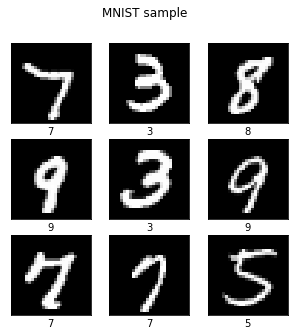

In [2]:
utils.show_numbers(x_train_sample, y_train_sample, title=f"MNIST sample")

Here we start the training executor definition. We need the following things:

**Input**
- Python script: `training.py`
- Parameters for the script: `model_name`, `x_train_path`, `y_train_path`, etc.
- requirements: `req_training.txt`, the required libraries to build the training image.

**Output**
- The input dataset for both training and testing (x_train, x_test, ...) will be saved in Tracker Repository (MLflow) to have a data version control.
- Model (mnist_cnn) and version (1,2,3 and on) will be saved and registered in the Tracker Repository. It will save the artifacts (serialized model) and register the model in the Model Registry.

Eventually, the data scientist will select a model version (from the Model Registry) and tag it as a "Production" Model. So that, this model will be use in the Inference stage.

In [56]:
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(1,'../..')
from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker, Predictor
from scanflow.special import Supervisor, Checker, Improver, Planner 
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# We can define a list of executors. 
# In this case, we only have one executor.
executors = [Executor(name='training', 
                      file='training.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'epochs':7,
                                  'x_train_path': './mnist_sample/train_images.npy', 
                                  'y_train_path': './mnist_sample/train_labels.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      requirements='req_training.txt')           
            ]

# A workflow contains a list of executors and also special nodes. 
# In this case, we have only one special node: Tracker MLflow.
workflow1 = Workflow(name='training-mnist', 
                     executors=executors,
                     tracker=Tracker()) # No agents involved
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

14-May-21 14:54:45 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['training-mnist']
)

All the experiments will be saved at MLflow UI: http://localhost:8002 (Tracker repository). It contains also the Model registry (where all the model versions are registered).

Once we have defined the training executor we can then build the corresponding images and start the workflow.

In [57]:
# If you got a ConnectionResetError, just run it again (maybe a port is bound)
deployer = Deploy(setup)

deployer.build_workflows(True) # verbose=True
deployer.start_workflows(True) # verbose=True

14-May-21 14:54:47 -  WARNING - [+] Network: [network_scanflow] is already running.
14-May-21 14:54:47 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-repository/docker-compose.yml] was created successfully.
14-May-21 14:54:47 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-repository/main.py] was created successfully.
14-May-21 14:54:47 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-verbose/docker-compose.yml] was created successfully.
14-May-21 14:54:47 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-verbose/main.py] was created successfully.
14-May-21 14:54:47 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-swarm/docker-compose.yml] was created successfully.
14-May-21 14:54:47 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/st

Now we have a Docker container of name: {workflow-name}-{executor-name} running on the computer.

Then, we run the workflow to execute the script (in our case, training.py) inside the new created container. It performs the model training and then save a model version in the Model Registry (http://localhost:8002/#/models).


In [58]:
deployer.run_workflows(verbose=False)

100%|██████████| 1/1 [00:07<00:00,  8.00s/it]


In [3]:
# Of course you can stop the workflows, 
# it will stop and prune all the created containers.
# deployer.stop_workflows()

07-May-21 11:06:31 -  INFO - [+] Environment: [training-mnist-training] was stopped successfully.
07-May-21 11:06:31 -  INFO - [+] Tracker: [tracker-mlflow] is not running in local.
07-May-21 11:06:31 -  INFO - [+] Stopped containers were pruned.
07-May-21 11:06:31 -  INFO - [+] Network: [network_training-mnist] is not running in local.


After this first definition, you will end up with two new containers, one for the training executor and the other for the tracker.

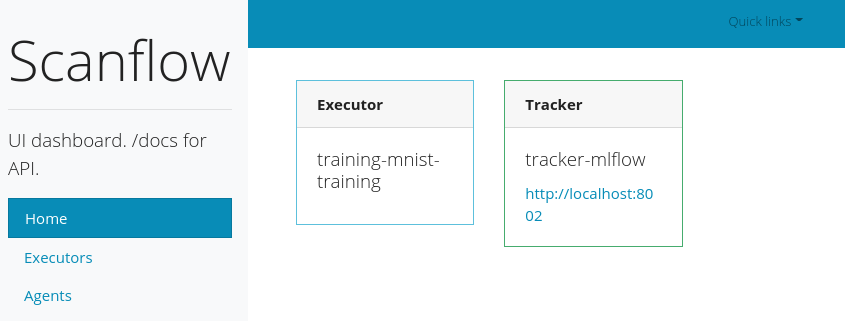

In [46]:
from IPython.display import Image
Image("sc/training.png", width=500, height=500)

## Model (inference)



This stage involves making predictions. It can be of two types, namely Batch and Online. 

### Batch

This executor makes predictions for big inputs at once. Similar to the training part, we define the inference executor (**batch**). To do so, we need the following:

- Python script: `inference-batch.py`
- Parameters for the script: `x_inference_path`, `model_name` and `model_version`.
- requirements: `req_inference_batch.txt`, the required libraries to build the inference image.

In [55]:
# This executor can receive any mnist model name and version (from Model Registry).
# This inference is of type "batch", meaning that the inference 
# is done by a python script (predict) and not deployed as an API (REST).

executors = [Executor(name='inference', 
                      file='inference-batch.py',
                      parameters={'model_name':'mnist_cnn',
                                  'model_version':'1',
#                                   'model_stage':'Production',
                                  },
                      image='training-mnist-training')           
            ]


workflow1 = Workflow(name='inference-mnist', 
                     executors=executors,
                     tracker=Tracker())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

14-May-21 13:29:58 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['inference-mnist']
)

In [52]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()
# deployer.pipeline() # Build, Start and Run all together

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


In [54]:
# deployer.run_workflows(True)

In [5]:
# deployer.stop_workflows()

### Online

Here we define the online version of the previous executor. It produces realtime predictions. This requires a service node that can expose a webserver. This special service is called a Predictor.

- **Predictor**: this node creates both the UI (http://localhost:8010) and API (http://localhost:8011) for the **online** inference. It requires the `predictor.py` that is similar to the `inference-batch.py`. Located at `stuff/predictor/predictor.py`


In [35]:
# Almost with the same previous executor code you can get an online predictor.


predictor = Predictor(file ='predictor.py', # located at stuff/predictor
                      image='training-mnist-training', #reuse the training image
                      port = 8010,
                      function = 'main') # function inside predictor.py that has the I/O.

workflow1 = Workflow(name='inference-mnist', 
                     tracker=Tracker(), #mlflow
                     predictor=predictor)
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

13-May-21 13:42:04 -  INFO - [Predictor] Port 8010 is set successfully.
13-May-21 13:42:04 -  INFO - [Tracker] Port 8002 is set successfully.



Setup = (
    Workflows: ['inference-mnist']
)

In [37]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()
# deployer.pipeline() # Build, Start and Run all together

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


In [38]:
# deployer.stop_workflows()

You can go to http://localhost:8010 to see the UI app. You will see this capture:

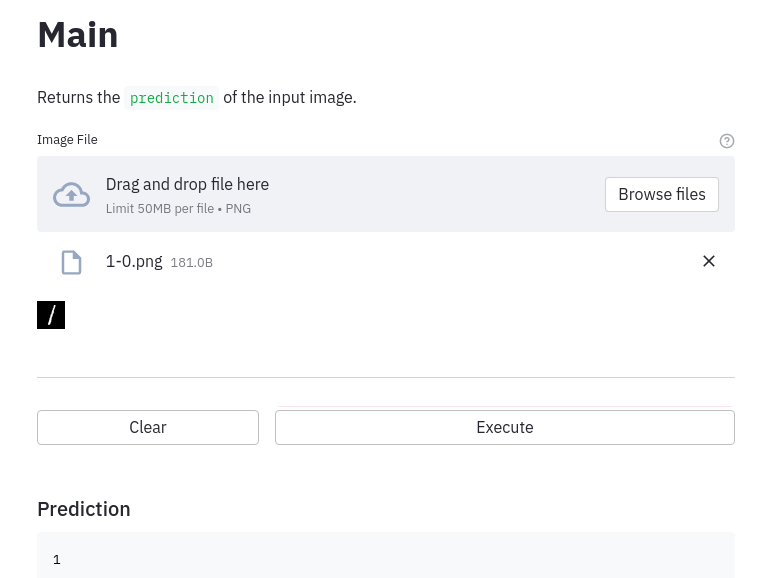

In [40]:
from IPython.display import Image
Image("sc/predictor_ui.png", width=500, height=500)

Also, you will see something like the following capture when running the API (http://localhost:8011)

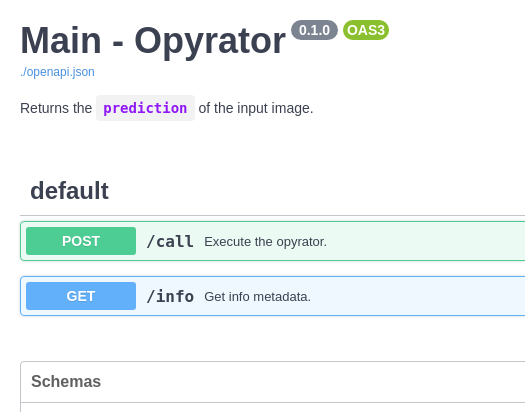

In [41]:
from IPython.display import Image
Image("sc/predictor_api.png", width=500, height=500)

## Agents

Here we define four built-in agents that will provide continuous monitoring over the inference stage.

- **Supervisor**: this agent is in charge of linking the multi agent system to the outside. For instance, it can get the `x_inference` and feed it to the Checker agent. Located at `stuff/supervisor/agent/supervisor_agent.py`
- **Checker**: this agent calls the Drift Detector executor to get the anomalies and the chosen instances to be considered for the retraining. The Checker's output is the feedback. `stuff/supervisor/agent/checker_agent.py`
- **Improver**: this agent decides what to do with the feedback. For instance, if n_anomalies > threshold, then use the Retraining executor to perform a retraining with `x_train + x_chosen`. `stuff/supervisor/agent/improver_agent.py`
- **Planner**: this agent receives the order from the Improver to make some changes in the original workflow. For instance, change the current "Production" model by the new created model from the Improver. `stuff/supervisor/agent/planner_agent.py`

In [6]:
workflow1 = Workflow(name='inference-mnist', 
                     tracker=Tracker(), #mlflow
                     
                     supervisor=Supervisor(),
                     checker=Checker(),
                     improver=Improver(),
                     planner=Planner())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

13-May-21 00:08:21 -  INFO - [Tracker] Port 8002 is in use by Tracker.
13-May-21 00:08:21 -  INFO - [Supervisor] Port 8003 is in use by Supervisor.
13-May-21 00:08:21 -  INFO - [Checker] Port 8004 is in use by Checker.
13-May-21 00:08:21 -  INFO - [Improver] Port 8005 is in use by Improver.
13-May-21 00:08:21 -  INFO - [Planner] Port 8006 is in use by Planner.



Setup = (
    Workflows: ['inference-mnist']
)

In [8]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()
# deployer.pipeline() # Build, Start and Run all together

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Then you can go to the Scanflow dashboard (http://localhost:8050/agents) and see the running agents.

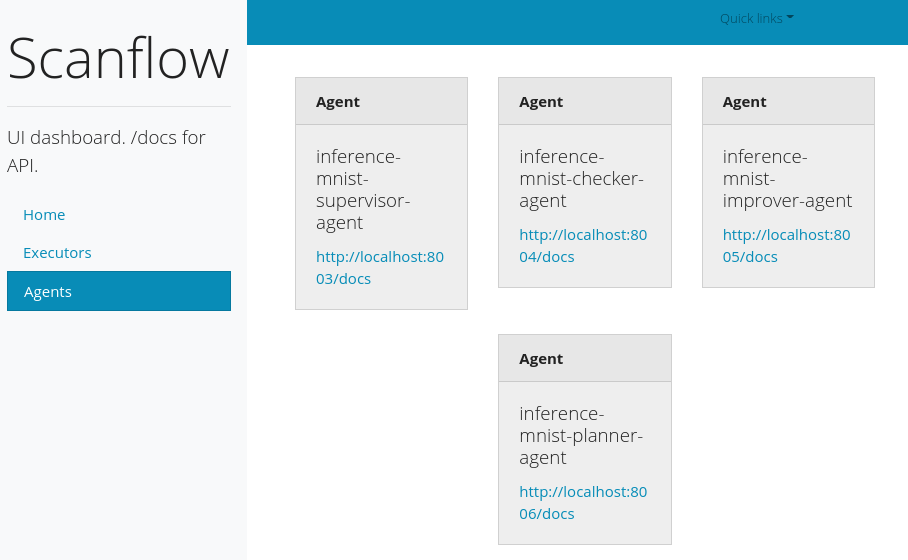

In [45]:
from IPython.display import Image
Image("sc/agents.png", width=500, height=500)

## Detector (training)

This executor trains the drift detector using the **x_train**. It learns the original distribution patterns to then detect if the **x_inference** follows a similar one.

In [35]:
# This detector-batch comprises an anomaly detector and a picker
executors = [Executor(name='detector-training', 
                      file='detector-training.py',
                      parameters={'name': 'detector_mnist',
                                  'x_train_path': './mnist_sample/train_images.npy',
                                  },
                      requirements='req_detector.txt')           
            ]


workflow1 = Workflow(name='detector-training-mnist', 
                     executors=executors,
                     tracker=Tracker())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup


Setup = (
    Workflows: ['detector-training-mnist']
)

In [36]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)
# deployer.pipeline() # Build, Start and Run

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 12:26:36 -  INFO - [++] Starting workflow: [detector-training-mnist].
10-May-21 12:26:36 -  INFO - [+] Starting image: [detector-training-mnist:detector-training].
10-May-21 12:26:36 -  WARNING - [+] Environment: [detector-training-mnist-detector-training] is already running.
10-May-21 12:26:36 -  INFO - [+] Starting image: [tracker-mlflow.
10-May-21 12:26:36 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
10-May-21 12:26:36 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 12:26:36 -  INFO - [+] [containers_alive.json] was loaded successfully.
10-May-21 12:26:36 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 12:26:37 -  INFO - [+] Workflow: [detector-training-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


In [8]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 10:24:58 -  INFO - [++] Running workflow: [detector-training-mnist].
10-May-21 10:24:58 -  INFO - [+] Running image: [detector-training-mnist:detector-training].
10-May-21 10:25:05 -  INFO - [+] Running (detector-training.py). 
10-May-21 10:25:05 -  INFO - [+] Output:  2021-05-10 08:24:59.664977: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-05-10 08:24:59.665020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-05-10 08:25:01.764991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-10 08:25:01.765798: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.

In [30]:
# deployer.stop_workflows()

## Detector (inference)

This executor contains the detector (for inference) and the picker. This detector will be used by the Checker agent.

In [37]:
# This detector-batch comprises an anomaly detector and a picker
# It requires the inference run_id from where to get the artifacts.
# Apart from the run_id it requires the artifact paths. 
# Both run_id and artifact paths can be changed dynamically.

executors = [Executor(name='detector-batch', 
                      file='detector-batch.py',
                      parameters={'run_id': 'inference_run_id', 
                                  'x_inference_artifact': 'x_inference.npy',
                                  'y_inference_artifact': 'y_inference.npy'
                                 },
                      requirements='req_detector.txt')           
            ]

workflow1 = Workflow(name='detector-inference-mnist', 
                     executors=executors,
                     tracker=Tracker())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

10-May-21 12:26:39 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['detector-inference-mnist']
)

In [38]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)
# deployer.pipeline() # Build, Start and Run

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 12:26:40 -  INFO - [++] Starting workflow: [detector-inference-mnist].
10-May-21 12:26:40 -  INFO - [+] Starting image: [detector-inference-mnist:detector-batch].
10-May-21 12:26:40 -  WARNING - [+] Environment: [detector-inference-mnist-detector-batch] is already running.
10-May-21 12:26:40 -  INFO - [+] Starting image: [tracker-mlflow.
10-May-21 12:26:40 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
10-May-21 12:26:41 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 12:26:41 -  INFO - [+] [containers_alive.json] was loaded successfully.
10-May-21 12:26:41 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 12:26:41 -  INFO - [+] Workflow: [detector-inference-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


In [33]:
# deployer.stop_workflows()

06-May-21 20:31:30 -  INFO - [+] Environment: [detector-inference-mnist-detector-batch] was stopped successfully.
06-May-21 20:31:30 -  INFO - [+] Tracker: [tracker-mlflow] is not running in local.
06-May-21 20:31:30 -  INFO - [+] Stopped containers were pruned.
06-May-21 20:31:30 -  INFO - [+] Network: [network_detector-inference-mnist] is not running in local.


In [58]:
# deployer.run_workflows(verbose=True)

## Retraining

This executor will be used by the Improver agent to retrain the model. So that, the new training dataset will be as follows:

**Without human intervention**

> x_new_train = x_train + x_chosen.

> y_new_train = y_train + y_predicted.

**With human intervention**

> x_new_train = x_train + x_chosen.

> y_new_train = y_train + y_human_labeled.

In [39]:
executors = [Executor(name='retraining', 
                      file='retraining.py',
                      parameters={'model_name': 'mnist_cnn_retrained',
                                  'run_id': 'inference_run_id',
                                  'x_new_train_artifact': 'x_inference.npy', 
                                  'y_new_train_artifact': 'y_inference.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      image='training-mnist-training') #reuse the training image         
            ]


workflow1 = Workflow(name='retraining-mnist', 
                     executors=executors,
                     tracker=Tracker())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

10-May-21 12:26:57 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['retraining-mnist']
)

In [40]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 12:26:59 -  INFO - [++] Starting workflow: [retraining-mnist].
10-May-21 12:26:59 -  INFO - [+] Starting image: [retraining-mnist:retraining].
10-May-21 12:26:59 -  WARNING - [+] Environment: [retraining-mnist-retraining] is already running.
10-May-21 12:26:59 -  INFO - [+] Starting image: [tracker-mlflow.
10-May-21 12:26:59 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
10-May-21 12:26:59 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 12:26:59 -  INFO - [+] [containers_alive.json] was loaded successfully.
10-May-21 12:26:59 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 12:27:00 -  INFO - [+] Workflow: [retraining-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


In [59]:
# deployer.run_workflows(verbose=True)

In [16]:
# deployer.stop_workflows()

## Labeling (Human agent)

It contains the Active learning step. Available soon

# **Productionizing** 🖥️

## Custom App

Scanflow provides a ready-to-use app (UI) when creating a `Predictor` node (http://localhost:8010/), this built-in app allows the user 
to set up quickly the predictor's input and output. In most of 
the cases, this is enough to start making predictions.

However, there might be situations where a node is part of a big 
system or a pipeline that can use several technologies. 
Therefore, it is useful to embed a node inside another application. For instance, embed an executor (inference batch) or a Predictor API.

The following scripts provide custom apps that deploy an executor (batch) 
and a Predictor API (online). For this example we provide two apps using `gradio` to create custom UIs:

- `pip install gradio`
- `python app_batch.py mnist_cnn 1`
- `python app_online.py mnist_cnn 1`

Where `mnist_cnn` is the model's name and `1` its version. You can find them at http://localhost:8002/#/models

You should see this UI when running `app_batch.py` (by default at http://localhost:7860/)

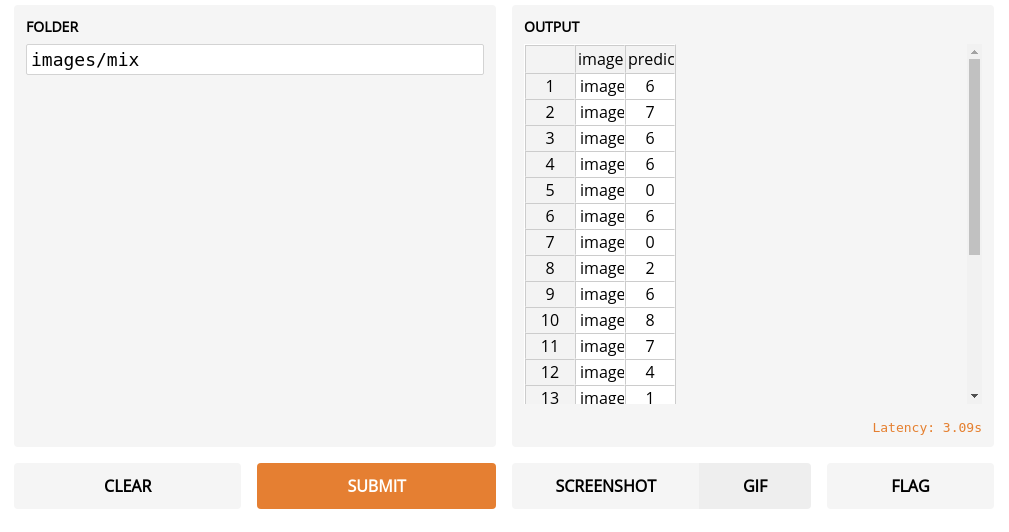

In [48]:
from IPython.display import Image
Image("sc/app_batch.png", width=500, height=500)

Basically what we need is to call the Scanflow API to run the 
inference batch executor:

```python
model_name = sys.argv[1]
model_version = int(sys.argv[2])

base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

scanflow_uri = 'http://localhost:8050/run/executor'
app_dir = '/home/guess/Desktop/scanflow/examples/demo_mnist/'
filename = 'x_inference_dashboard.npy'

content = {'name': 'inference-mnist-inference',
          'parameters':{'model_name':model_name, 
                        'model_version': model_version,
                        'x_inference_path': filename}}

def inference(x_inference):
    
    x_inference_path = os.path.join(app_dir, 'workflow',
                                filename)
    y_inference_path = os.path.join(app_dir, 'workflow',
                            'y_inference.csv')
    
    with open(x_inference_path, 'wb') as f:
        np.save(f, x_inference)

    response = requests.post(
        url=scanflow_uri,
        data = json.dumps(content)
    )    
    print(response)

    predictions = pd.read_csv(y_inference_path)
    
    return predictions['predictions'].values
```

Similarly, this is the output when running `app_online.py` (by default at http://localhost:7861/)

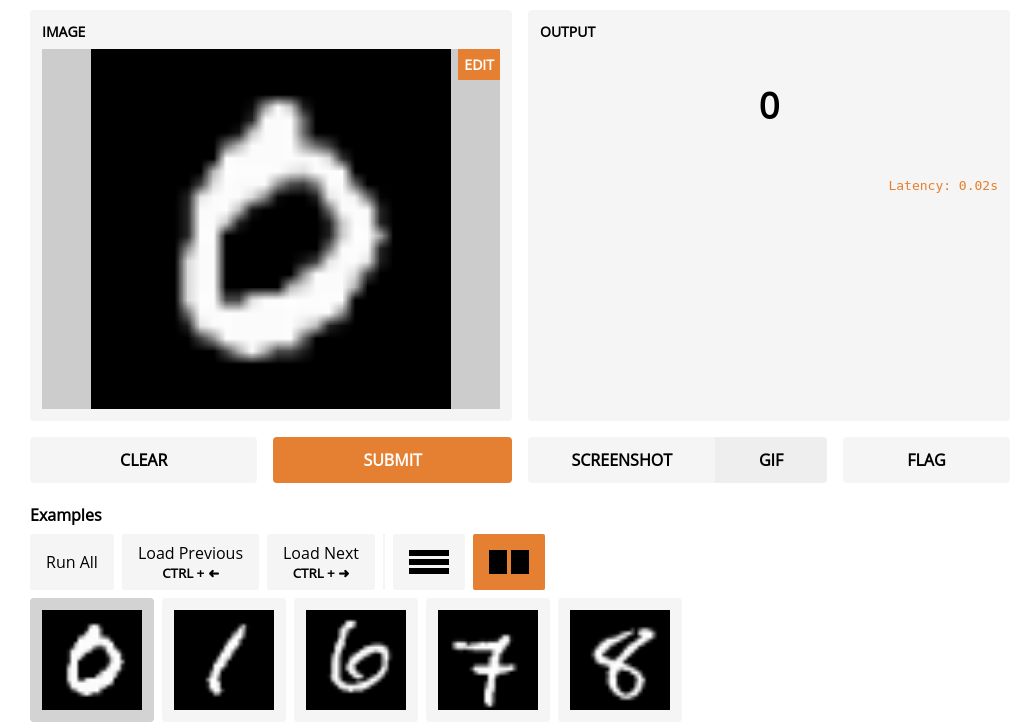

In [46]:
from IPython.display import Image
Image("sc/app_online.png", width=500, height=500)

Here, instead, we call the Predictor API to get predictions:

```python
model_name = sys.argv[1]
model_version = int(sys.argv[2])

def inference(image):
    img = Image.fromarray(image).convert("L")

    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    image_str = base64.b64encode(img_byte_arr).decode()
    
    predictor_api = 'http://localhost:8011/call'

    content = {'image_file': image_str}

    response = requests.post(
        url=predictor_api,
        data = json.dumps(content)
    )    
    result = json.loads(response.text)
    
    return result['prediction']
```

## Agent Explanation

It provides the explanation of each agent decision.

Please go to http://localhost:8050/agents and you will see something like this:

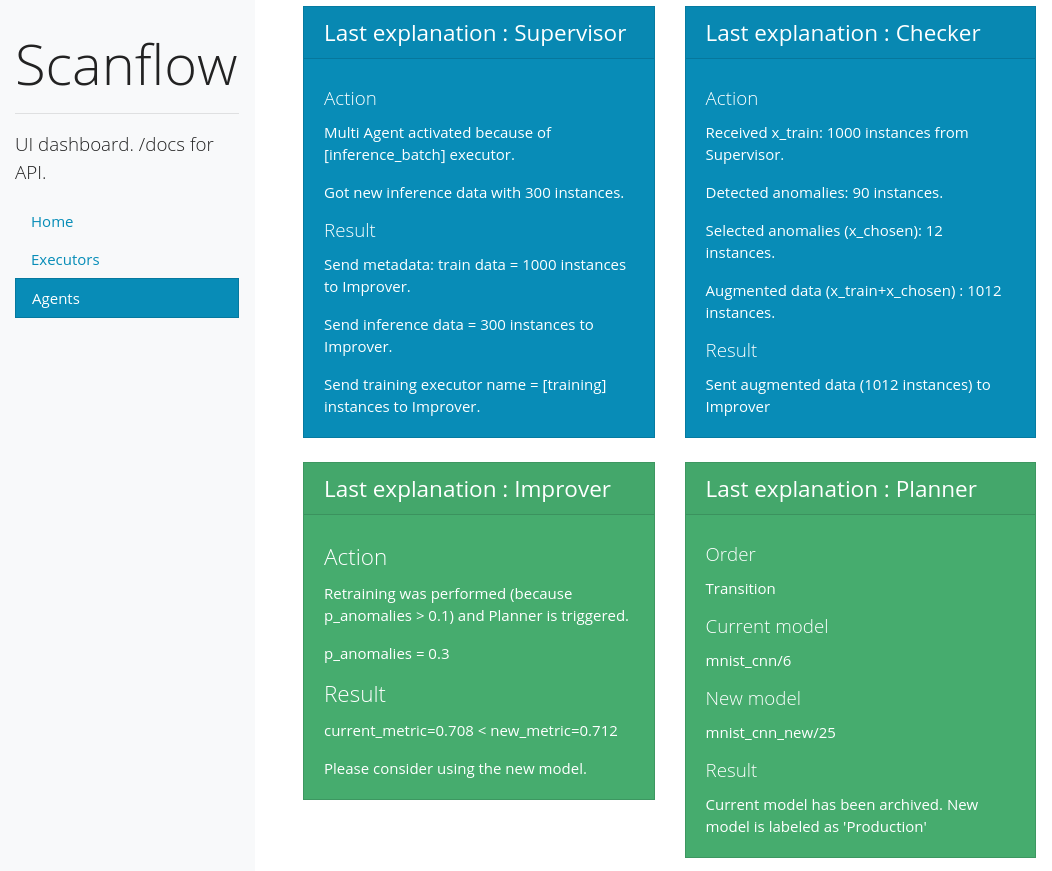

In [62]:
from IPython.display import Image
Image("sc/agents_explanation.png", width=700, height=700)

Here we have 4 cards, regarding the Supervisor, Checker, Improver and Planner,
respectively, each of one shows an explanation once an inference is detected.

For instance, the Supervisor card explains that the system has been activated 
due to the inference_batch executor and received 300 instances.
The second card, Checker, says that 90 of 1000 instances were anomalies and 
12 of them were chosen to be used as labels. This information is sent to the Improver.

This Improver agent performs a retraining because the condition
was fulfilled (percentage_anomalies>0.1), then the improver found that the 
new metric (new model score) is better than the current one (0.712>0.708). This 
result triggers the Planner.

Finally, the Planner labels the new model as 'Production' and archives the older one.

# Remove metadata

It will remove artifacts, metrics, params and also registered models.

In [1]:
import pandas as pd
import os
import sys
sys.path.insert(0,'../..')

from scanflow import track

base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")
tracker = track.Tracker(app_dir)
# last_artifacts = tracker.list_artifacts(workflow_name='mnist')
# print(last_artifacts.keys())


In [9]:
# tracker.delete_tracked_data()